In [2]:
import argparse
import sys
import os
from skimage import io

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches



from tqdm import tqdm

# from scheduler import CycleScheduler
from pt_utils import  Embeddings, Trainer, VQVAE, data_sampler
from torch.utils import data
from torch import distributed as dist

from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from torchsummary import summary

# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm
import torchvision
from PIL import Image

import numpy as np
from pt_utils import Encoder, Decoder, all_reduce, Quantize
from torch.nn import functional as F


In [126]:
class QuantizeAdaptive(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input, n_embedded_l=None, dim_l=None):
        
        flatten = input.reshape(-1, self.dim)
        dist = (
                flatten.pow(2).sum(1, keepdim=True)
                - 2 * flatten @ self.embed[:,:n_embedded_l]
                + self.embed[:,:n_embedded_l].pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            all_reduce(embed_onehot_sum)
            all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                    (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()
        
        if dim_l!=None:
            quantize[:,:,:,dim_l:]=0
        
        # return quantize[:,:,:,:dim_l], diff, embed_ind
        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))
    
class Vqvae2Adaptive(nn.Module):
    def __init__(
            self,
            in_channel=3,
            channel=128,
            n_res_block=5,
            n_res_channel=32,
            embed_dim=64,
            n_embed=512,
            decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = QuantizeAdaptive(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = QuantizeAdaptive(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input,n_embedded_l, dim_l):
        quant_t, quant_b, diff, _, _ = self.encode(input,n_embedded_l=n_embedded_l, dim_l=dim_l)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input,n_embedded_l, dim_l):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t, n_embedded_l=n_embedded_l, dim_l=dim_l )
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b, n_embedded_l=n_embedded_l, dim_l=dim_l )

        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def encode_t(self, input, n_embedded_l=1, dim_l=1 ):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t, n_embedded_l=n_embedded_l, dim_l=dim_l )
        quant_t = quant_t.permute(0, 3, 1, 2)

        return quant_t

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec


In [127]:
device = "cuda"
model = Vqvae2Adaptive(in_channel=3,
# model = VQVAE(in_channel=3,
              channel=128,
              n_res_block=6,
              n_res_channel=32,
              embed_dim=8,
              n_embed=8192,
              decay=0.99).to(device)

# model_file = 'data/logs/emb_dim_1_n_embed_8192_bc_right_sub_left_minmax_4x_360/vqvae_003_train_0.04287_test_0.04129.pt'
model_file = 'data/logs/emb_dim_8_n_embed_8192_bc_left_9x_512_360/vqvae_002_train_0.02079_test_0.02053.pt'

model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda')))

<All keys matched successfully>

In [124]:
a=np.array([1,2,3])

a[-1:]=0

a

array([1, 2, 0])

In [70]:
dataset_path = '../datasets/original/o_bc_left_9x_512_360'

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

dataset = datasets.ImageFolder(dataset_path, transform=transform)

dataset_path = dataset.__dict__['root']
classes_folders = os.listdir(dataset_path)
classes_folders_images = [os.listdir(dataset_path + '/' + folder) for folder in classes_folders]
classes_folders_images_num = [len(os.listdir(dataset_path + '/' + folder)) for folder in classes_folders]
img_transform = dataset.__dict__['transform']

In [83]:
i=0
j=0

image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

image = Image.open(image_path).convert("RGB")
image = img_transform(image).unsqueeze(0).to(device)

quant_t= model.encode_t(image,n_embedded_l=-2, dim_l=-2)

In [15]:
quant_t, quant_b, diff, id_t, id_b = model.encode(image,n_embedded_l=-2, dim_l=-2)

In [150]:
i=0
j=0

image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

image = Image.open(image_path).convert("RGB")
image = img_transform(image).unsqueeze(0).to(device)


# dec, diff = model.forward(image,n_embedded_l=None, dim_l=None)

for n_embedded in [None, -4096, -6144,-7000, -8000    ]:
    for dim in [None, -1, -2, -3, -4, -5, -6, -7]:
        dec, diff = model(image,n_embedded_l=n_embedded, dim_l=dim)
        
        grid = utils.make_grid(dec, normalize=True)
        ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        
        io.imsave(f'{n_embedded},{dim}.png',ndarr)

# plt.figure(figsize=(5,5))

# plt.imshow(255-ndarr, cmap='gray')
# plt.show()

In [20]:
S=np.load('S.npy')

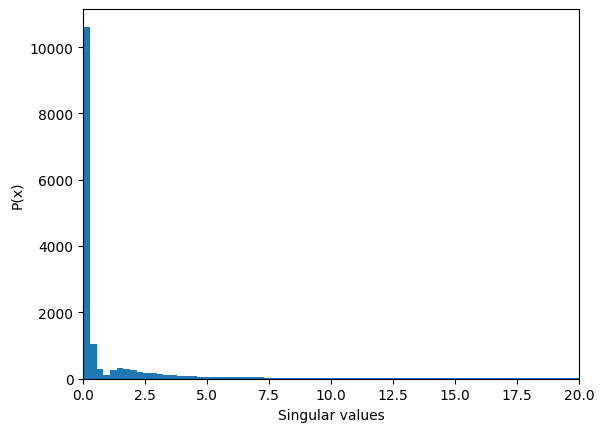

In [46]:
g=plt.hist(S, bins=10000)
plt.xlim(0,20)
plt.xlabel('Singular values')
plt.ylabel('P(x)')
plt.show()

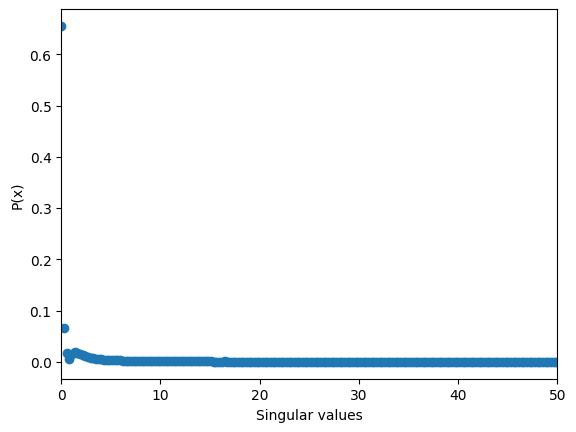

In [43]:
hist, bin_edges=np.histogram(S, bins=10000)
hist=hist/np.sum(hist)

plt.xlim(0,50)
plt.xlabel('Singular values')
plt.ylabel('P(x)')

plt.scatter(bin_edges[:-1], hist)